In [1]:
#| default_exp models.nhits

In [2]:
#| hide
%load_ext autoreload
%autoreload 2

# N-HiTS

In [3]:
#| export
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from neuralforecast.losses.pytorch import MAE
from neuralforecast.common._base_windows import BaseWindows

In [4]:
#| hide
from fastcore.test import test_eq
from nbdev.showdoc import show_doc
from neuralforecast.utils import generate_series

In [5]:
#| hide
import logging
import warnings

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

#plt.rcParams["axes.grid"]=True
plt.rcParams['font.family'] = 'serif'
#plt.rcParams["figure.figsize"] = (4,2)

In [6]:
#| export
class _IdentityBasis(nn.Module):
    def __init__(self, backcast_size: int, forecast_size: int, interpolation_mode: str):
        super().__init__()
        assert (interpolation_mode in ['linear','nearest']) or ('cubic' in interpolation_mode)
        self.forecast_size = forecast_size
        self.backcast_size = backcast_size
        self.interpolation_mode = interpolation_mode
 
    def forward(self, theta: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        backcast = theta[:, :self.backcast_size]
        knots = theta[:, self.backcast_size:]

        if self.interpolation_mode=='nearest':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif self.interpolation_mode=='linear':
            knots = knots[:,None,:]
            forecast = F.interpolate(knots, size=self.forecast_size, mode=self.interpolation_mode)
            forecast = forecast[:,0,:]
        elif 'cubic' in self.interpolation_mode:
            batch_size = len(backcast)
            knots = knots[:,None,None,:]
            forecast = torch.zeros((len(knots), self.forecast_size)).to(knots.device)
            n_batches = int(np.ceil(len(knots)/batch_size))
            for i in range(n_batches):
                forecast_i = F.interpolate(knots[i*batch_size:(i+1)*batch_size], size=self.forecast_size, mode='bicubic')
                forecast[i*batch_size:(i+1)*batch_size] += forecast_i[:,0,0,:]

        return backcast, forecast

In [7]:
#| exporti
ACTIVATIONS = ['ReLU',
               'Softplus',
               'Tanh',
               'SELU',
               'LeakyReLU',
               'PReLU',
               'Sigmoid']

POOLING = ['MaxPool1d',
           'AvgPool1d']

class NHITSBlock(nn.Module):
    """
    N-HiTS block which takes a basis function as an argument.
    """
    def __init__(self, 
                 input_size: int,
                 h: int,
                 n_theta: int,
                 mlp_units: list,
                 basis: nn.Module,
                 futr_exog_size: int,
                 hist_exog_size: int,
                 stat_exog_size: int,
                 n_pool_kernel_size: int,
                 pooling_mode: str,
                 dropout_prob: float,
                 activation: str):
        """
        """
        super().__init__()

        pooled_hist_size = int(np.ceil(input_size/n_pool_kernel_size))
        pooled_futr_size = int(np.ceil((input_size+h)/n_pool_kernel_size))

        input_size = pooled_hist_size + \
                     hist_exog_size*pooled_hist_size + \
                     futr_exog_size*(pooled_futr_size) + stat_exog_size

        self.dropout_prob = dropout_prob
        self.futr_exog_size = futr_exog_size
        self.hist_exog_size = hist_exog_size
        self.stat_exog_size = stat_exog_size
        
        assert activation in ACTIVATIONS, f'{activation} is not in {ACTIVATIONS}'
        assert pooling_mode in POOLING, f'{pooling_mode} is not in {POOLING}'

        activ = getattr(nn, activation)()

        self.pooling_layer = getattr(nn, pooling_mode)(kernel_size=n_pool_kernel_size,
                                                       stride=n_pool_kernel_size, ceil_mode=True)

        # Block MLPs
        hidden_layers = [nn.Linear(in_features=input_size, 
                                   out_features=mlp_units[0][0])]
        for layer in mlp_units:
            hidden_layers.append(nn.Linear(in_features=layer[0], 
                                           out_features=layer[1]))
            hidden_layers.append(activ)

            if self.dropout_prob>0:
                raise NotImplementedError('dropout')
                #hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=mlp_units[-1][1], out_features=n_theta)]
        layers = hidden_layers + output_layer
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, futr_exog: torch.Tensor,
                hist_exog: torch.Tensor, stat_exog: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

        # Pooling
        # Pool1d needs 3D input, (B,C,L), adding C dimension
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        # Flatten MLP inputs [B, L+H, C] -> [B, (L+H)*C]
        # Contatenate [ Y_t, | X_{t-L},..., X_{t} | F_{t-L},..., F_{t+H} | S ]
        batch_size = len(insample_y)
        if self.hist_exog_size > 0:
            hist_exog = hist_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            hist_exog = self.pooling_layer(hist_exog)
            hist_exog = hist_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, hist_exog.reshape(batch_size,-1) ), dim=1)

        if self.futr_exog_size > 0:
            futr_exog = futr_exog.permute(0,2,1) # [B, L, C] -> [B, C, L]
            futr_exog = self.pooling_layer(futr_exog)
            futr_exog = futr_exog.permute(0,2,1) # [B, C, L] -> [B, L, C]
            insample_y = torch.cat(( insample_y, futr_exog.reshape(batch_size,-1) ), dim=1)

        if self.stat_exog_size > 0:
            insample_y = torch.cat(( insample_y, stat_exog.reshape(batch_size,-1) ), dim=1)
            
        # Compute local projection weights and projection
        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta)
        return backcast, forecast

In [8]:
#| export
class NHITS(BaseWindows):
    def __init__(self, 
                 input_size,
                 h,
                 stack_types: list = ['identity', 'identity', 'identity'],
                 n_blocks: list = [1, 1, 1],
                 mlp_units: list = 3 * [[512, 512]],
                 n_pool_kernel_size: list = [2, 2, 1],
                 n_freq_downsample: list = [4, 2, 1],
                 pooling_mode: str = 'MaxPool1d',
                 interpolation_mode: str = 'linear',
                 dropout_prob_theta = 0.,
                 activation = 'ReLU',
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 learning_rate=1e-3,
                 scaler_type=None,
                 windows_batch_size: int = 1024,
                 step_size: int = 1,
                 loss=MAE(),
                 batch_size=32, 
                 num_workers_loader=0,
                 drop_last_loader=False,
                 random_seed=1,
                 **trainer_kwargs):
        """
        N-HiTS Model.
        
        **Parameters:**<br>
        `input_size`: int, insample_size.<br>
        `h`: int, Forecast horizon. <br>
        `shared_weights`: bool, If True, all blocks within each stack will share parameters. <br>
        `activation`: str, Activation function. An item from ['ReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU', 'PReLU', 'Sigmoid']. <br>
        `futr_exog_list`: List[str], List of future exogenous variables. <br>
        `hist_exog_list`: List[str], List of historic exogenous variables. <br>
        `stack_types`: List[str], List of stack types. Subset from ['seasonality', 'trend', 'identity'].<br>
        `n_blocks`: List[int], Number of blocks for each stack. Note that len(n_blocks) = len(stack_types).<br>
        `mlp_units`: List[List[int]], Structure of hidden layers for each stack type. Each internal list should contain the number of units of each hidden layer. Note that len(n_hidden) = len(stack_types).<br>
        `n_harmonics`: int, Number of harmonic terms for trend stack type. Note that len(n_harmonics) = len(stack_types). Note that it will only be used if a trend stack is used.<br>
        `n_polynomials`: int, Number of polynomial terms for seasonality stack type. Note that len(n_polynomials) = len(stack_types). Note that it will only be used if a seasonality stack is used.<br>
        `dropout_prob_theta`: float, Float between (0, 1). Dropout for N-BEATS basis.<br>
        `learning_rate`: float, Learning rate between (0, 1).<br>
        `loss`: Callable, Loss to optimize.<br>
        `random_seed`: int, random_seed for pseudo random pytorch initializer and numpy random generator.<br>
        """
        super(NHITS, self).__init__(h=h, 
                                    loss=loss,
                                    batch_size=batch_size,
                                    scaler_type=scaler_type,
                                    futr_exog_list=futr_exog_list,
                                     hist_exog_list=hist_exog_list,
                                     stat_exog_list=stat_exog_list,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    **trainer_kwargs)
        self.input_size = input_size
        self.learning_rate = learning_rate
        self.windows_batch_size = windows_batch_size
        self.step_size = step_size
        self.futr_exog_size = len(self.futr_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)

        blocks = self.create_stack(stack_types=stack_types, 
                                   n_blocks=n_blocks,
                                   input_size=input_size,
                                   h=h,
                                   mlp_units=mlp_units,
                                   n_pool_kernel_size=n_pool_kernel_size,
                                   n_freq_downsample=n_freq_downsample,
                                   pooling_mode=pooling_mode,
                                   interpolation_mode=interpolation_mode,
                                   dropout_prob_theta=dropout_prob_theta,
                                   activation=activation,
                                   futr_exog_size=self.futr_exog_size,
                                   hist_exog_size=self.hist_exog_size,
                                   stat_exog_size=self.stat_exog_size)
        self.blocks = torch.nn.ModuleList(blocks)
        
        # Adapter with Loss dependent dimensions
        if self.loss.outputsize_multiplier > 1:
            self.out = nn.Linear(in_features=h,
                        out_features=h*self.loss.outputsize_multiplier)

    def create_stack(self, stack_types, 
                     n_blocks, 
                     input_size, 
                     h, 
                     mlp_units,
                     n_pool_kernel_size,
                     n_freq_downsample,
                     pooling_mode,
                     interpolation_mode,
                     dropout_prob_theta, 
                     activation,
                     futr_exog_size, hist_exog_size, stat_exog_size):                     

        block_list = []
        for i in range(len(stack_types)):
            for block_id in range(n_blocks[i]):

                assert stack_types[i] == 'identity', f'Block type {stack_types[i]} not found!'

                n_theta = (input_size + max(h//n_freq_downsample[i], 1) )
                basis = _IdentityBasis(backcast_size=input_size,
                                       forecast_size=h,
                                       interpolation_mode=interpolation_mode)                 

                nbeats_block = NHITSBlock(input_size=input_size,
                                          h=h,
                                          n_theta=n_theta,
                                          mlp_units=mlp_units,
                                          n_pool_kernel_size=n_pool_kernel_size[i],
                                          pooling_mode=pooling_mode,
                                          basis=basis,
                                          dropout_prob=dropout_prob_theta,
                                          activation=activation,
                                          futr_exog_size=futr_exog_size,
                                          hist_exog_size=hist_exog_size,
                                          stat_exog_size=stat_exog_size)

                # Select type of evaluation and apply it to all layers of block
                block_list.append(nbeats_block)
                
        return block_list

    def forward(self, windows_batch):
        
        # Parse windows_batch
        insample_y    = windows_batch['insample_y']
        insample_mask = windows_batch['insample_mask']
        futr_exog     = windows_batch['futr_exog']
        hist_exog     = windows_batch['hist_exog']
        stat_exog     = windows_batch['stat_exog']
        
        # insample
        residuals = insample_y.flip(dims=(-1,)) #backcast init
        insample_mask = insample_mask.flip(dims=(-1,))
        forecast = insample_y[:, -1:] # Level with Naive1

        block_forecasts = [ forecast.repeat(1, self.h) ]
        
        for i, block in enumerate(self.blocks):
            backcast, block_forecast = block(insample_y=residuals, futr_exog=futr_exog,
                                             hist_exog=hist_exog, stat_exog=stat_exog)
            residuals = (residuals - backcast) * insample_mask
            forecast = forecast + block_forecast
            if self.decompose_forecast:
                block_forecasts.append(block_forecast)

        if self.decompose_forecast:
            # (n_batch, n_blocks, h)
            block_forecasts = torch.stack(block_forecasts)
            block_forecasts = block_forecasts.permute(1,0,2)
            return block_forecasts
        else:
            
            # Last dimension Adapter
            if self.loss.outputsize_multiplier > 1:
                forecast = forecast[:,:,None] + \
                          self.loss.adapt_output(self.out(forecast))
            return forecast

In [9]:
show_doc(NHITS)

---

[source](https://github.com/Nixtla/neuralforecast/tree/main/blob/main/neuralforecast/models/nhits.py#L153){target="_blank" style="float:right; font-size:smaller"}

### NHITS

>      NHITS (input_size, h, stack_types:list=['identity', 'identity',
>             'identity'], n_blocks:list=[1, 1, 1], mlp_units:list=[[512, 512],
>             [512, 512], [512, 512]], n_pool_kernel_size:list=[2, 2, 1],
>             n_freq_downsample:list=[4, 2, 1], pooling_mode:str='MaxPool1d',
>             interpolation_mode:str='linear', dropout_prob_theta=0.0,
>             activation='ReLU', futr_exog_list=None, hist_exog_list=None,
>             stat_exog_list=None, learning_rate=0.001, scaler_type=None,
>             windows_batch_size:int=1024, step_size:int=1,
>             loss=<neuralforecast.losses.pytorch.MAE object at 0x13b1c4580>,
>             batch_size=32, num_workers_loader=0, drop_last_loader=False,
>             random_seed=1, **trainer_kwargs)

Hooks to be used in LightningModule.

In [10]:
show_doc(NHITS.fit, name='NHITS.fit')

---

### NHITS.fit

>      NHITS.fit (dataset, val_size=0, test_size=0)

Fits Model.

**Parameters:**<br>
`dataset`: TimeSeriesDataset.<br>
`trainer`: pl.Trainer.<br>
`val_size`: int, validation size.<br>
`test_size`: int, test size.<br>
`data_kwargs`: extra arguments to be passed to TimeSeriesDataModule.

In [11]:
show_doc(NHITS.predict, name='NHITS.predict')

---

### NHITS.predict

>      NHITS.predict (dataset, test_size=None, step_size=1, **data_kwargs)

Predicts Model.

**Parameters:**<br>
`dataset`: TimeSeriesDataset.<br>
`trainer`: pl.Trainer.<br>
`step_size`: int, Step size between each window.<br>
`data_kwargs`: extra arguments to be passed to TimeSeriesDataModule.

In [12]:
#| hide
import logging
import warnings
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

<AxesSubplot: xlabel='ds'>

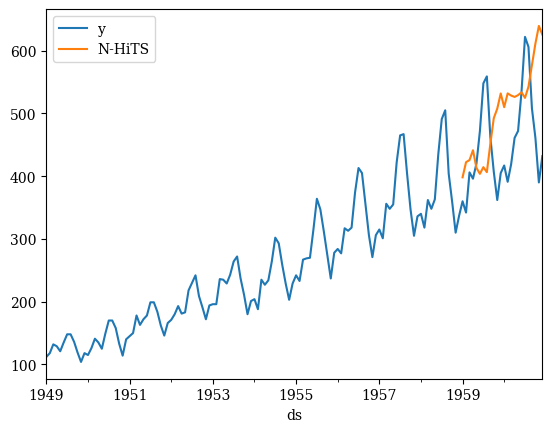

In [13]:
#| hide
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl

from neuralforecast.utils import AirPassengersDF as Y_df
from neuralforecast.tsdataset import TimeSeriesDataset, TimeSeriesLoader

Y_train_df = Y_df[Y_df.ds<Y_df['ds'].values[-24]] # 132 train
Y_test_df = Y_df[Y_df.ds>=Y_df['ds'].values[-24]]   # 12 test

dataset, *_ = TimeSeriesDataset.from_df(df = Y_train_df)
model = NHITS(input_size=24*2, h=24, 
              max_epochs=1,
              windows_batch_size=None, 
              n_freq_downsample=[12,4,1], 
              pooling_mode='MaxPool1d')
model.fit(dataset=dataset)
y_hat = model.predict(dataset=dataset)
Y_test_df['N-HiTS'] = y_hat

pd.concat([Y_train_df, Y_test_df]).drop('unique_id', axis=1).set_index('ds').plot()

Predicting: 0it [00:00, ?it/s]

Text(0.5, 0, 'Prediction τ ∈ {t+1,..., t+H}')

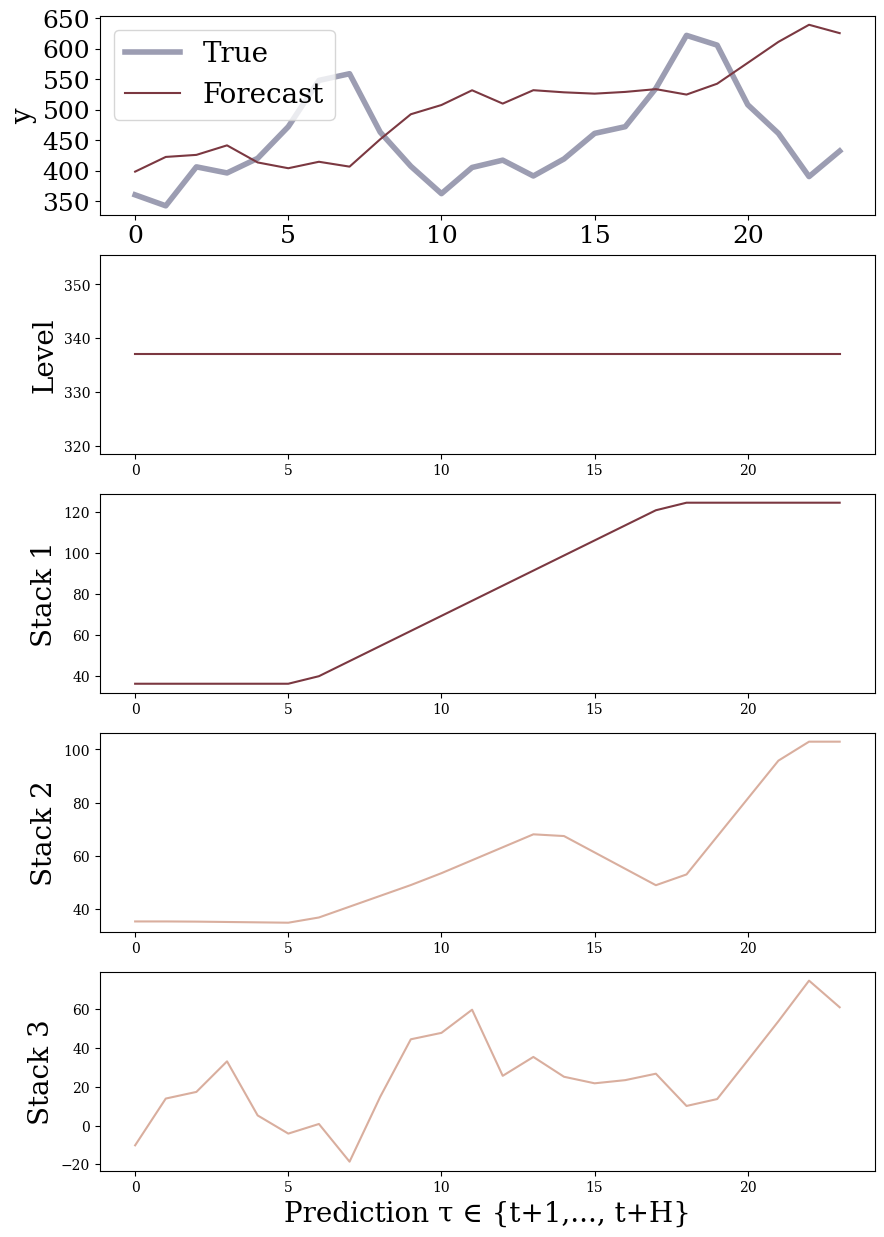

In [14]:
#| hide
fig, ax = plt.subplots(5, 1, figsize=(10, 15))

y_hat = model.decompose(dataset=dataset)
ax[0].plot(Y_test_df['y'].values, label='True', color="#9C9DB2", linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend(prop={'size': 20})
for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
    label.set_fontsize(18)
ax[0].set_ylabel('y', fontsize=20)

ax[1].plot(y_hat[0,0], label='level', color="#7B3841")
ax[1].set_ylabel('Level', fontsize=20)

ax[2].plot(y_hat[0,1], label='stack1', color="#7B3841")
ax[2].set_ylabel('Stack 1', fontsize=20)

ax[3].plot(y_hat[0,2], label='stack2', color="#D9AE9E")
ax[3].set_ylabel('Stack 2', fontsize=20)

ax[4].plot(y_hat[0,3], label='stack3', color="#D9AE9E")
ax[4].set_ylabel('Stack 3', fontsize=20)

ax[4].set_xlabel('Prediction \u03C4 \u2208 {t+1,..., t+H}', fontsize=20)